In [1]:
# importing needed libraries and data ...

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

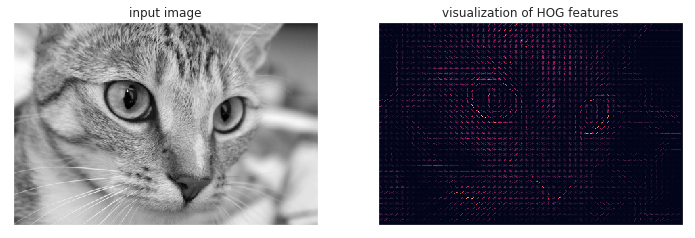

In [2]:
from skimage import data, color, feature
import skimage.data

# RGB -> Gray
# Choosing simple image from data set.
image = color.rgb2gray(data.chelsea())

# Extracting HOG fea1tures ...
hog_vec, hog_vis = feature.hog(image,visualize=True )

# drawing a canvas
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

# drawing main Chosen image and it's HOG features.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');


In [3]:
# getting positive Data set -> those containing human face.

from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images

# check it out ...
positive_patches.shape

(13233, 62, 47)

In [4]:
from skimage import data, transform

# getting 10 picture...
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

# extracting negative pictures 
# and convert them to gray Scale.
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

# check it out
len(images)

10

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

# getting thumbnails from them at a variety of scale
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape


(30000, 62, 47)

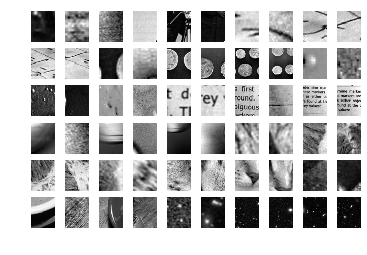

In [6]:
# take a look at a few of them to get an idea of what they look like

fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    
    # just looking at random 60 images -> number : 500 , 1000 , 1500 , ... 
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')


In [7]:
## NOTE:
# this part takes a little while because
#the HOG features involve a significant computation for each image so stay Calm :)))

from itertools import chain

# extracting HOG features...
# using chain to combine both positive and negative patches ...
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])

# usign binary labels 
    # 1.contians human face : 1
    # O.W : 0
    
y_train = np.zeros(X_train.shape[0])

# positive patches contain human Faces so the label is 1.
y_train[:positive_patches.shape[0]] = 1

# check it out.
X_train.shape


(43233, 1215)

In [8]:
# this part is optional
# using simple Gaussian Naive bayes
# just 4 Fun.

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# check the result out.
cross_val_score(GaussianNB(), X_train, y_train)

# for me the result was Shocking!!!
# because it shows that simply our faces are more likely to 
# be on a gaussian Curve !!!

/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.95385469, 0.97349247, 0.97501908])

In [9]:
# fun is enough!!!
# let's go to SVM trainig method.

# I chosed LinearSVC because it is better that usual SVC
#  and has better scaling for large number of samples.
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# register Grid
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})

# training ...
grid.fit(X_train, y_train)

# getting accuracy ...
grid.best_score_


/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/amirhosein/anaconda3/lib/python3.7/site-packages/sklearn/

0.9891286748548562

In [10]:
# getting which param is better for this dataSet.
# again my curiosity
grid.best_params_

{'C': 1.0}

In [11]:
# fitting best one to our DataSet.
# which as you see is the one with : { 'C' : 1.0 }

# getting the best one.
model = grid.best_estimator_

# retraining ...
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

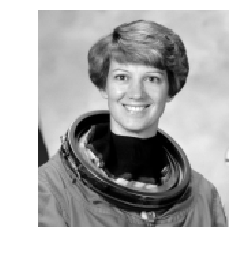

In [24]:
# let's grab a new image and see how the model does. 

# NOTE : I used astronaut's picture.(since it was mentioned in HW.)

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5) 
test_image = test_image[:160, 40:180]


plt.imshow(test_image, cmap='gray')
plt.axis('off');


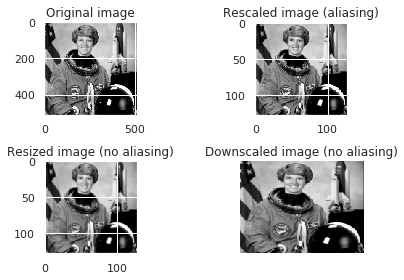

In [25]:
# NOTE : 

# 1.rescales causes aliasing and it is obvious according to it's implementation
# so if you wanna avoid aliasing you can simply use these keyWords(downsample & resize) instead.
# but i tried both of them and the result doesnt change significantly.

# conclusion:

# rescale : causes aliasing.
# resize : no aliasing.
# downsample : no aliasing.

import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean

image = color.rgb2gray(data.astronaut())

image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.axis('off');
plt.show()


In [35]:
# without using pyramid!!!

# Now let's create window that iterates over patches
# of this image, and compute HOG features for each patch:


def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=4, jstep=4, scale=1.0):
    
    # high istep&jstep -> more accurancy
    # low  istep&jstep -> less accurancy
    
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    # iterating window over image...
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            # extracting window
            patch = img[i:i + Ni, j:j + Nj]
            
            if scale != 1:
                patch = transform.resize(patch, patch_size)
                
            yield (i, j), patch

# getting sliding windows over our image.
indices, patches = zip(*sliding_window(test_image))

# getting HOG features of created Sliding windows.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# check it out
print(patches_hog.shape)

# let's use our model to evaluate whether each patch contains a face:
labels = model.predict(patches_hog)

# number of accepted Labels.
labels.sum()

(500, 1215)


12.0

In [27]:
## training using image pyramid
# image pyramiding ...

from cv2 import cv2
from skimage.transform import pyramid_gaussian
pyramid = tuple(pyramid_gaussian(test_image, downscale=2, multichannel=False))

def sliding_window(img, model, patch_size=positive_patches[0].shape,
                   istep=8, jstep=8, scale=1.0):
    
    # high istep&jstep -> more accurancy
    # low  istep&jstep -> less accurancy
    
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    # iterating window over image...
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Nj, jstep):
            # extracting window
            patch = img[i:i + Ni - 1 , j:j + Nj - 1]
            
            if scale != 1:
                patch = resize(patch, patch_size)
            
            patches_hog = np.array(feature.hog(patch))
            label = model.predict(patches_hog.reshape(1, -1))
            dis = model.decision_function(patches_hog.reshape(1,-1))
            if label == 1 and dis > 0.5:
                cv2.imshow("Image5 detected face",patch)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
            yield (i, j, dis), label

rects = []
Ni, Nj = (s for s in positive_patches[0].shape)
for image in pyramid:
    if (image.shape[0] < Ni) or (image.shape[1] < Nj):
        continue
    mag = test_image.shape[0] / image.shape[0]
    # getting sliding windows over our image.
    indices, labels = zip(*sliding_window(image,model))
    

    indices = np.array(indices)
    for i, j, dis in indices:
        rects.append([int(j*mag),int(i*mag),int((j+Nj)*mag),int((i+Ni)*mag)])


165


In [23]:
#import the necessary packages
import numpy as np

def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    
    x1 = np.array([])
    y1 = np.array([])
    x2 = np.array([])
    y2 = np.array([])
    
    for i in range(len(boxes)):

        x1 = np.append(x1,[boxes[i][0]])
        y1 = np.append(y1,[boxes[i][1]])
        x2 = np.append(x2,[boxes[i][2]])
        y2 = np.append(y2,[boxes[i][3]])
        
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
        
     
    output = []
    for i in range(len(pick)):
        
        temp = boxes[pick[i]]
        
        # adding offsets.
        # somhow instead of padding each rectangle.
        temp[1] = temp[1] - 12;
        temp[3] = temp[3] - 12;
        
        output.append(temp)
        
    print(output)
    
    return output

# Note: It is 100 time faster than slow one!!!

# The SLOW-implementation(above) required an extra inner for
# loop to compute the size of bounding regions and compute the ratio of overlapped area.
# in this implementation( FAST ) I replaced this inner for loop with vectorized code 
# and this is how we are able to achieve substantially faster speeds when applying non-maximum suppression.

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
   
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    
    x1 = np.array([])
    y1 = np.array([])
    x2 = np.array([])
    y2 = np.array([])
    
    for i in range(len(boxes)):

        x1 = np.append(x1,[boxes[i][0]])
        y1 = np.append(y1,[boxes[i][1]])
        x2 = np.append(x2,[boxes[i][2]])
        y2 = np.append(y2,[boxes[i][3]])
        
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    
    output = []
    for i in range(len(pick)):
        temp = boxes[pick[i]]
        
        # adding offsets.
        # somhow instead of padding each rectangle.
        temp[1] = temp[1] - 12;
        temp[3] = temp[3] - 12;
        
        output.append(temp)
    print(output)
    
    return output

[[48, 32, 95, 94]]


(-0.5, 139.5, 159.5, -0.5)

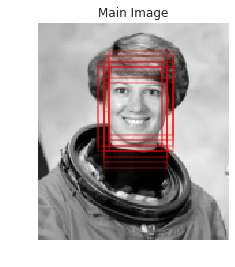

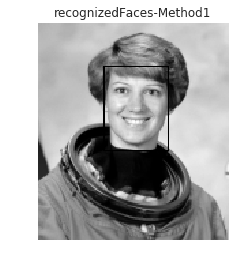

In [38]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

rects = []
counter = 0
for i, j in indices[labels == 1]:
    counter += 1
    if(counter%2 == 0):
        rects.append([j,i,j+Nj,i+Ni])
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
    

# now i Will remove multiple rectangles using different methods.
# 1. My first implementation : non_max_suppression_slow
# 2. My second implementation : non_max_suppression_fast
# 3. tensorFlow non_max_suppression



test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5) 
test_image = test_image[:160, 40:180]


plt.imshow(test_image, cmap='gray')
plt.title("Main Image")
plt.axis('off');


import cv2

# boxes containing Red Rectangles above...

# method 1: 
picks = non_max_suppression_slow(rects,0.3)

# method 2: 
#picks = non_max_suppression_fast(boxes,0.3)


# loop over the picked bounding boxes and draw them
for i in range(len(picks)):
    
    startX = picks[i][0]
    startY = picks[i][1]
    endX = picks[i][2]
    endY = picks[i][3]
    
    if(i<=1):
        cv2.rectangle(test_image, (startX, startY), (endX, endY), (0, 255, 0), 1)
    
fig, ax = plt.subplots()
ax.imshow(test_image,cmap = 'gray')
ax.set_title("recognizedFaces-Method1")
ax.axis('off')
# display  images